# Final Project 


# Sentiment Analysis of Amazon Reviews: An attention-based LSTM Approach

Zale Che

In [1]:
import numpy as np
import nltk
import random
import pandas as pd
import re

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.keras.layers import Bidirectional, Concatenate
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import GlobalAveragePooling1D

## Prepare Data

In [3]:
file = 'test.ft.txt'
with open(file) as f:
    test_lines = f.readlines()

In [4]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(test_lines,
                                       test_size=0.1,
                                       random_state=42)
print(len(train_set), len(test_set))

360000 40000


In [64]:
print(train_set[0])
print(test_set[0])

__label__2 Started out great, ended up with holes...: So easy to clean, and prevents scrubbing pans after baking! Everything slides right off.Update: 09/17/2009The silpat started falling apart and had holes in it. Didn't last as long as I hoped. Haven't bought another b/c of the price.

__label__2 This is a great book: I must preface this by saying that I am not religious - but I loved this book. I really enjoyed the story it was telling. To me this is more a story about where we come from as women, rather than some religious/biblical treatise. Reading this book you can really feel a connection with the character Dinah and the writer brings to life her world with colorful vividness. This book has an almost feminist feeling and to my great amusement paints Jacob as a villainous man who personifies most of the worst qualities one can have. This story sucked me in and I read it practically in one sitting. It was one of the best books I have read in a while.



In [6]:
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_set]

In [7]:
print(train_labels[:5])

[1, 1, 1, 1, 1]


In [8]:
test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_set]

In [9]:
print(test_labels[:5])

[1, 0, 1, 1, 0]


In [10]:
train_text = [x.split(' ', 1)[1][:-1] for x in train_set]  ##[:-1]拿到換行符號
test_text = [x.split(' ', 1)[1][:-1] for x in test_set]

## str.split(str="",num=string.count(str))[n]
## num:表示分割次數。如果存在引數num，則僅分隔成 num+1 個子字串，並且每一個子字串可以賦給新的變數
## [n]:表示選取第n個分片

In [11]:
print(train_text[0])
print(test_text[0])

Started out great, ended up with holes...: So easy to clean, and prevents scrubbing pans after baking! Everything slides right off.Update: 09/17/2009The silpat started falling apart and had holes in it. Didn't last as long as I hoped. Haven't bought another b/c of the price.
This is a great book: I must preface this by saying that I am not religious - but I loved this book. I really enjoyed the story it was telling. To me this is more a story about where we come from as women, rather than some religious/biblical treatise. Reading this book you can really feel a connection with the character Dinah and the writer brings to life her world with colorful vividness. This book has an almost feminist feeling and to my great amusement paints Jacob as a villainous man who personifies most of the worst qualities one can have. This story sucked me in and I read it practically in one sitting. It was one of the best books I have read in a while.


In [12]:
print (len(train_text))
print (len(train_labels))
print (len(test_text))
print (len(test_labels))

360000
360000
40000
40000


## Preprocess the text

In [13]:
## preprocess function
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    #to lowercase
    sentence = sentence.lower()

    return sentence

## Define removing html tags
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

In [14]:
train_text = [preprocess_text(t) for t in train_text]
test_text = [preprocess_text(t) for t in test_text]

In [15]:
print(train_text[0])
print(test_text[0])

started out great ended up with holes so easy to clean and prevents scrubbing pans after baking everything slides right off update the silpat started falling apart and had holes in it didn t last as long as i hoped haven t bought another b c of the price 
this is a great book i must preface this by saying that i am not religious but i loved this book i really enjoyed the story it was telling to me this is more a story about where we come from as women rather than some religious biblical treatise reading this book you can really feel a connection with the character dinah and the writer brings to life her world with colorful vividness this book has an almost feminist feeling and to my great amusement paints jacob as a villainous man who personifies most of the worst qualities one can have this story sucked me in and i read it practically in one sitting it was one of the best books i have read in a while 


## Tokenizer

In [16]:
NUM_WORDS = 10000
tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(train_text)

## Vocabulary

In [17]:
# determine the vocabulary size
# vocab_size = len(tokenizer.word_index) + 1
vocab_size = tokenizer.num_words + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 10001


In [18]:
list(tokenizer.word_index.items())[:20]

[('the', 1),
 ('i', 2),
 ('and', 3),
 ('a', 4),
 ('to', 5),
 ('it', 6),
 ('of', 7),
 ('this', 8),
 ('is', 9),
 ('in', 10),
 ('for', 11),
 ('that', 12),
 ('you', 13),
 ('was', 14),
 ('not', 15),
 ('s', 16),
 ('but', 17),
 ('with', 18),
 ('on', 19),
 ('book', 20)]

In [19]:
len(tokenizer.word_index)

225934

## Text to Sequences

In [20]:
## text to sequence
text_ints = tokenizer.texts_to_sequences(train_text)

In [21]:
## Check the text len distribution
text_lens = [len(n) for n in text_ints]

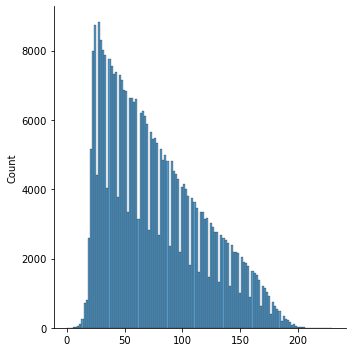

In [22]:
import seaborn as sns
sns.displot(text_lens)

In [23]:
## Find the maxlen of the texts
max_len = text_lens[np.argmax(text_lens)]
max_len

230

In [24]:
## Padding(most important in sentiment analysis)
max_len = 100  ## maximal text length, self-defined
text_ints_pad = sequence.pad_sequences(text_ints,
                                        maxlen=max_len,
                                        truncating='post',
                                        padding='post')
text_ints_pad[:50]

array([[ 360,   42,   31, ...,    0,    0,    0],
       [   4, 1538,  926, ...,   50,    7,    1],
       [  31,  491,   17, ...,    0,    0,    0],
       ...,
       [1635, 1294,   30, ...,  475,   35,   22],
       [ 710,  284,  128, ...,   25,  182,   11],
       [  32,   42,    7, ...,    0,    0,    0]], dtype=int32)

In [25]:
## Gereate X and y for training
X_train = np.array(text_ints_pad).astype('int32')
y_train = np.array(train_labels)

## Gereate X and y for testing in the same way
X_test = np.array(
    sequence.pad_sequences(tokenizer.texts_to_sequences(test_text),
                           maxlen=max_len,
                           padding='post',
                           truncating='post')).astype('int32')
y_test = np.array(test_labels)

In [26]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(360000, 100)
(360000,)
(40000, 100)
(40000,)


## Model Definition

In [27]:
## A few DL hyperparameters
BATCH_SIZE =128
EPOCHS = 15
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 128

In [28]:
## plotting
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

matplotlib.rcParams['figure.dpi'] = 150


# Plotting results
def plot1(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

In [29]:
## Model 1
model1 = Sequential()
model1.add(
    Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True))
model1.add(
    GlobalAveragePooling1D()
)  ## The GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
model1.add(Dense(16, activation="relu", name="dense_layer_1"))
model1.add(Dense(16, activation="relu", name="dense_layer_2"))
model1.add(Dense(1, activation="sigmoid", name="output"))

model1.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

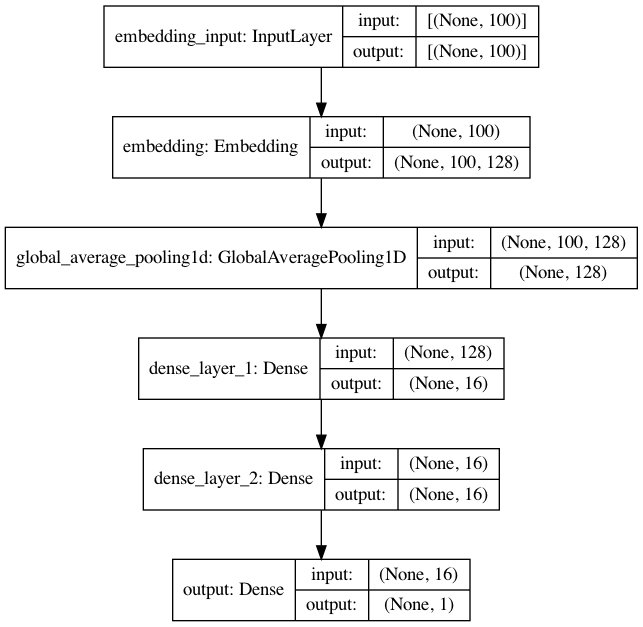

In [30]:
plot_model(model1, show_shapes=True)

In [31]:
history1 = model1.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/15
2250/2250 - 24s - loss: nan - accuracy: 0.6331 - val_loss: nan - val_accuracy: 0.5002
Epoch 2/15
2250/2250 - 22s - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5002
Epoch 3/15
2250/2250 - 22s - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5002
Epoch 4/15
2250/2250 - 23s - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5002
Epoch 5/15
2250/2250 - 24s - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5002
Epoch 6/15
2250/2250 - 23s - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5002
Epoch 7/15
2250/2250 - 23s - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5002
Epoch 8/15
2250/2250 - 24s - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5002
Epoch 9/15
2250/2250 - 24s - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5002
Epoch 10/15
2250/2250 - 23s - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5002
Epoch 11/15
2250/2250 - 24s -

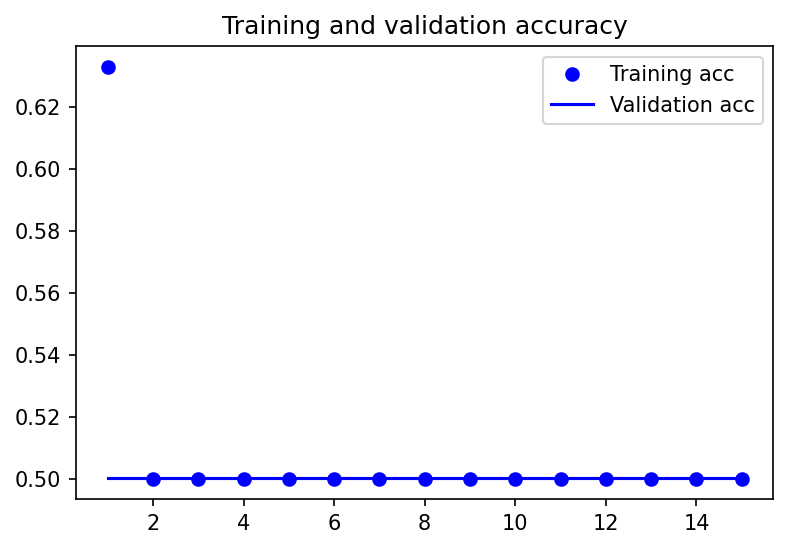

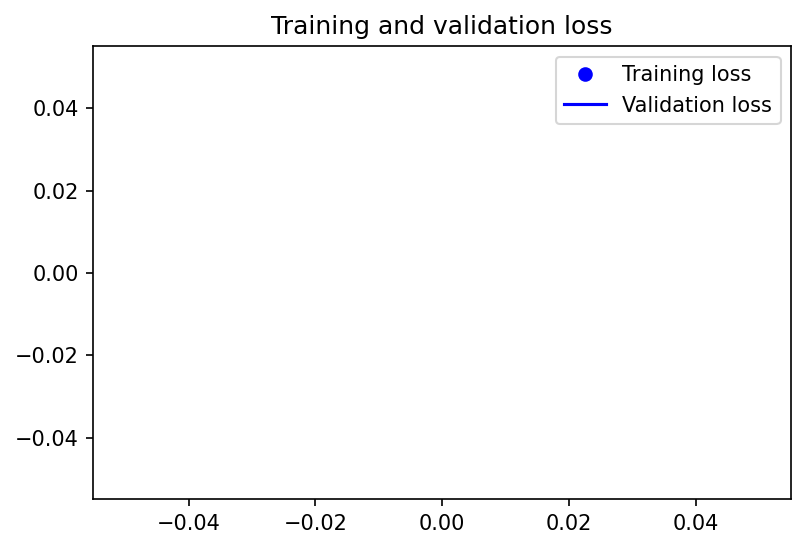

In [32]:
plot1(history1)

In [33]:
model1.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

313/313 - 1s - loss: nan - accuracy: 0.4998


[nan, 0.4997749924659729]

## More complex model with pre-trained embeddings

In [34]:
from numpy import array, asarray, zeros

embeddings_dictionary = dict()
glove_file = open ('glove/glove.6B.100d.txt', encoding='utf8')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [35]:
embedding_matrix = zeros((vocab_size, 100))

for word, index in list(tokenizer.word_index.items())[:10000]:
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        

### Bidirectional

In [36]:
## Model 2
model2 = Sequential()
model2.add(
    Embedding(input_dim=vocab_size,
              output_dim=100,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=False))
model2.add(Bidirectional(LSTM(16, dropout=0.2, recurrent_dropout=0.2)))
model2.add(Dense(1, activation="sigmoid"))

model2.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

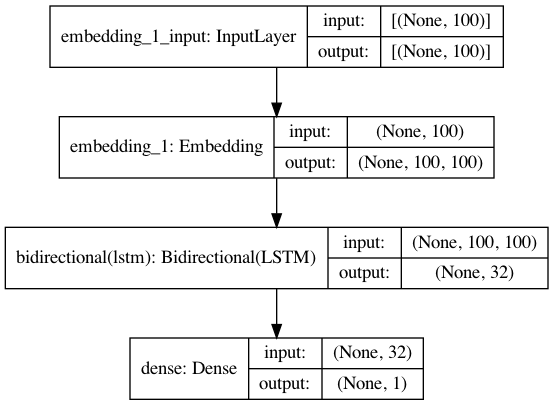

In [37]:
plot_model(model2, show_shapes=True)

In [38]:
history2 = model2.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=15,
                      verbose=2,
                      validation_split=0.2)

Epoch 1/15
2250/2250 - 293s - loss: 0.3609 - accuracy: 0.8415 - val_loss: 0.3062 - val_accuracy: 0.8690
Epoch 2/15
2250/2250 - 278s - loss: 0.2850 - accuracy: 0.8804 - val_loss: 0.2543 - val_accuracy: 0.8954
Epoch 3/15
2250/2250 - 263s - loss: 0.2636 - accuracy: 0.8905 - val_loss: 0.2423 - val_accuracy: 0.8995
Epoch 4/15
2250/2250 - 270s - loss: 0.2517 - accuracy: 0.8956 - val_loss: 0.2312 - val_accuracy: 0.9053
Epoch 5/15
2250/2250 - 334s - loss: 0.2439 - accuracy: 0.9000 - val_loss: 0.2260 - val_accuracy: 0.9087
Epoch 6/15
2250/2250 - 309s - loss: 0.2390 - accuracy: 0.9024 - val_loss: 0.2255 - val_accuracy: 0.9095
Epoch 7/15
2250/2250 - 400s - loss: 0.2335 - accuracy: 0.9053 - val_loss: 0.2202 - val_accuracy: 0.9102
Epoch 8/15
2250/2250 - 319s - loss: 0.2307 - accuracy: 0.9062 - val_loss: 0.2163 - val_accuracy: 0.9132
Epoch 9/15
2250/2250 - 342s - loss: 0.2279 - accuracy: 0.9075 - val_loss: 0.2176 - val_accuracy: 0.9119
Epoch 10/15
2250/2250 - 327s - loss: 0.2258 - accuracy: 0.9081 -

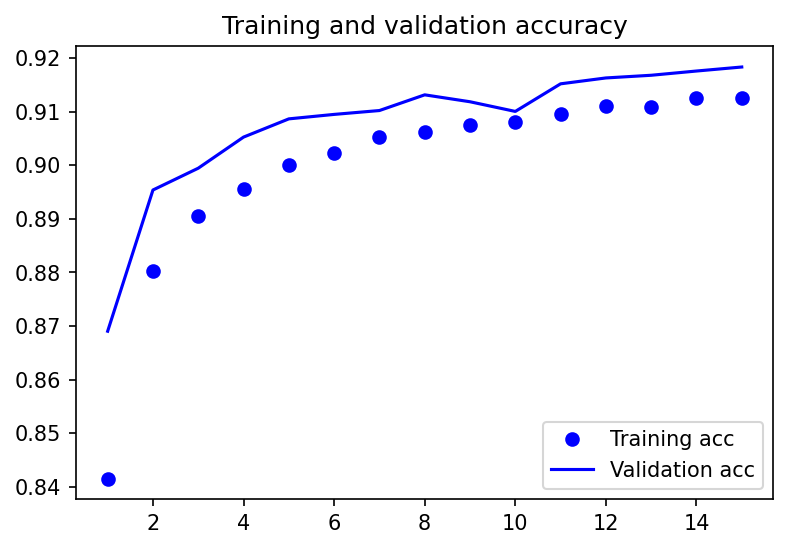

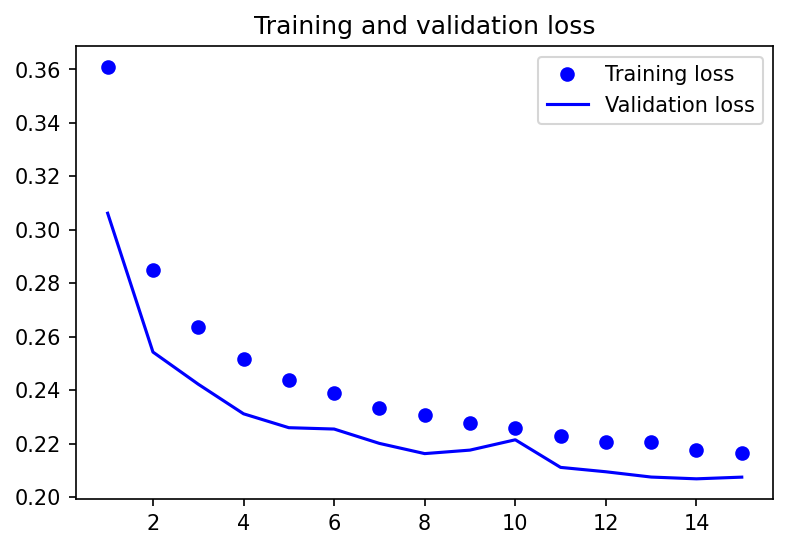

In [39]:
plot1(history2)

In [40]:
model2.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

313/313 - 7s - loss: 0.2076 - accuracy: 0.9179


[0.20764458179473877, 0.9178500175476074]

### Self-Attention

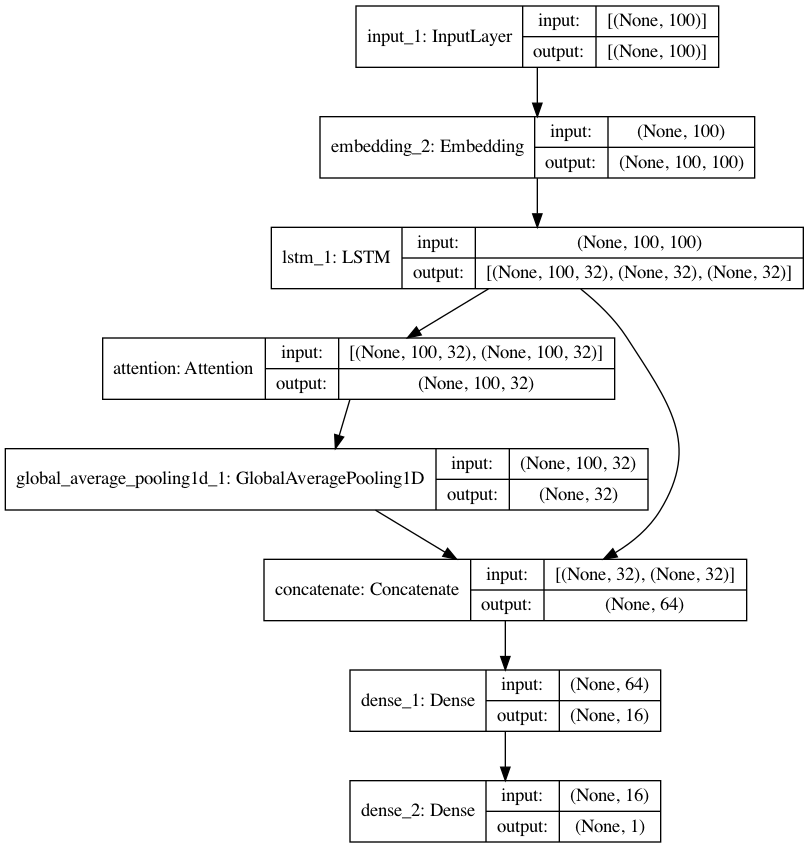

In [41]:
## Model 6 (Self-Attention)

inputs = Input(shape=(max_len, ))
x = Embedding(input_dim=vocab_size,
              output_dim=100,
              weights=[embedding_matrix],
              input_length=max_len,
                trainable=False)(inputs)
x_all_hs, x_last_h, x_last_c = LSTM(32,
                                    dropout=0.2,
                                    recurrent_dropout=0.2,
                                    return_sequences=True,
                                    return_state=True)(x)
## LSTM Parameters:
#     `return_seqeunces=True`: return the hidden states for each time step
#     `return_state=True`: return the cell state of the last time step
#     When both are set True, the return values of LSTM are:
#     (1) the hidden states of all time steps (when `return_sequences=True`) or the hidden state of the last time step
#     (2) the hidden state of the last time step
#     (3) the cell state of the last time step

## Self Attention
atten_out = Attention()([x_all_hs, x_all_hs])  # query and key
atten_out_average = GlobalAveragePooling1D()(atten_out)

x_last_h_plus_atten = Concatenate()([x_last_h, atten_out_average])
x = Dense(16, activation="relu")(x_last_h_plus_atten)
outputs = Dense(1, activation='sigmoid')(x)
model3 = Model(inputs=inputs, outputs=outputs)

plot_model(model3, show_shapes=True)

In [42]:
model3.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])
history3 = model3.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=15,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/15
2250/2250 - 258s - loss: 0.3680 - accuracy: 0.8355 - val_loss: 0.2727 - val_accuracy: 0.8864
Epoch 2/15
2250/2250 - 222s - loss: 0.2821 - accuracy: 0.8821 - val_loss: 0.2482 - val_accuracy: 0.8988
Epoch 3/15
2250/2250 - 267s - loss: 0.2599 - accuracy: 0.8922 - val_loss: 0.2355 - val_accuracy: 0.9062
Epoch 4/15
2250/2250 - 271s - loss: 0.2471 - accuracy: 0.8988 - val_loss: 0.2237 - val_accuracy: 0.9099
Epoch 5/15
2250/2250 - 246s - loss: 0.2387 - accuracy: 0.9028 - val_loss: 0.2183 - val_accuracy: 0.9119
Epoch 6/15
2250/2250 - 242s - loss: 0.2313 - accuracy: 0.9060 - val_loss: 0.2203 - val_accuracy: 0.9107
Epoch 7/15
2250/2250 - 240s - loss: 0.2274 - accuracy: 0.9079 - val_loss: 0.2147 - val_accuracy: 0.9137
Epoch 8/15
2250/2250 - 248s - loss: 0.2230 - accuracy: 0.9101 - val_loss: 0.2097 - val_accuracy: 0.9165
Epoch 9/15
2250/2250 - 231s - loss: 0.2198 - accuracy: 0.9113 - val_loss: 0.2050 - val_accuracy: 0.9184
Epoch 10/15
2250/2250 - 235s - loss: 0.2170 - accuracy: 0.9122 -

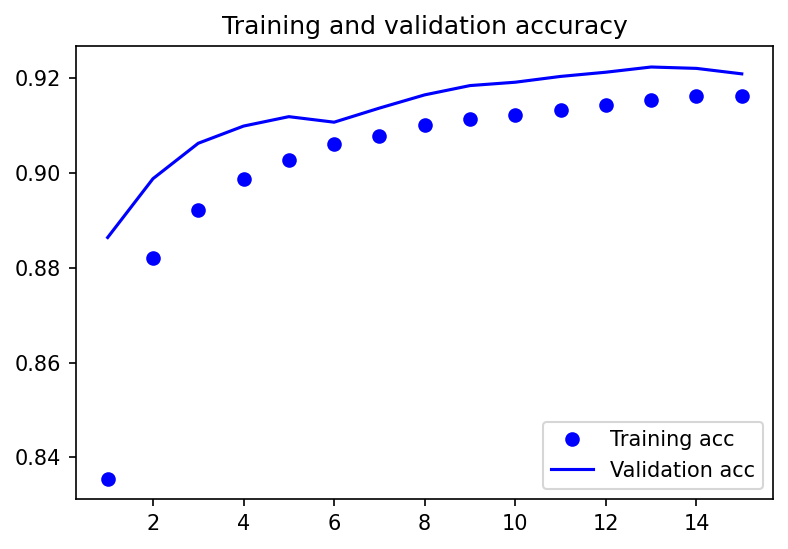

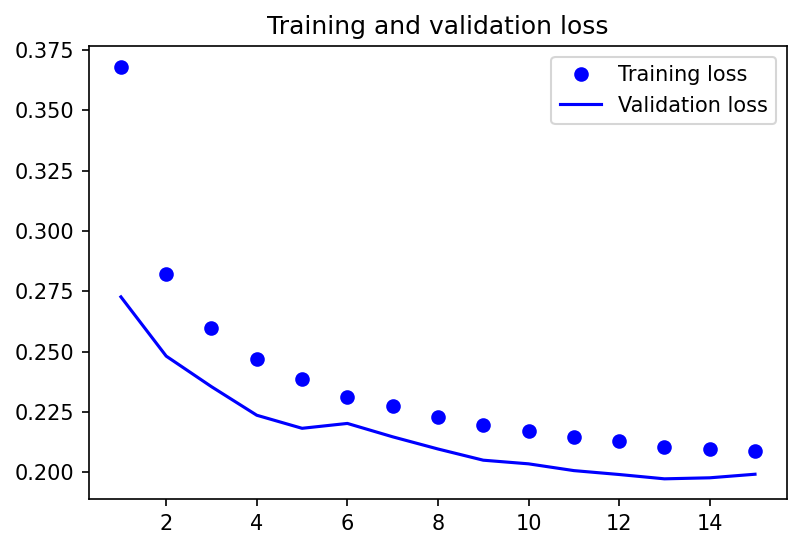

In [43]:
plot1(history3)

In [44]:
model3.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

313/313 - 10s - loss: 0.1988 - accuracy: 0.9209


[0.19877053797245026, 0.9208999872207642]

## Model Comparisons

In [68]:
history = [ history2, history3
]
history = [i.history for i in history]
model_names = [ 'LSTM-Bi-withPRE',
    'Self-attention-withPRE'
]

## Set color pallete
import seaborn as sns
qualitative_colors = sns.color_palette("Paired", len(history))

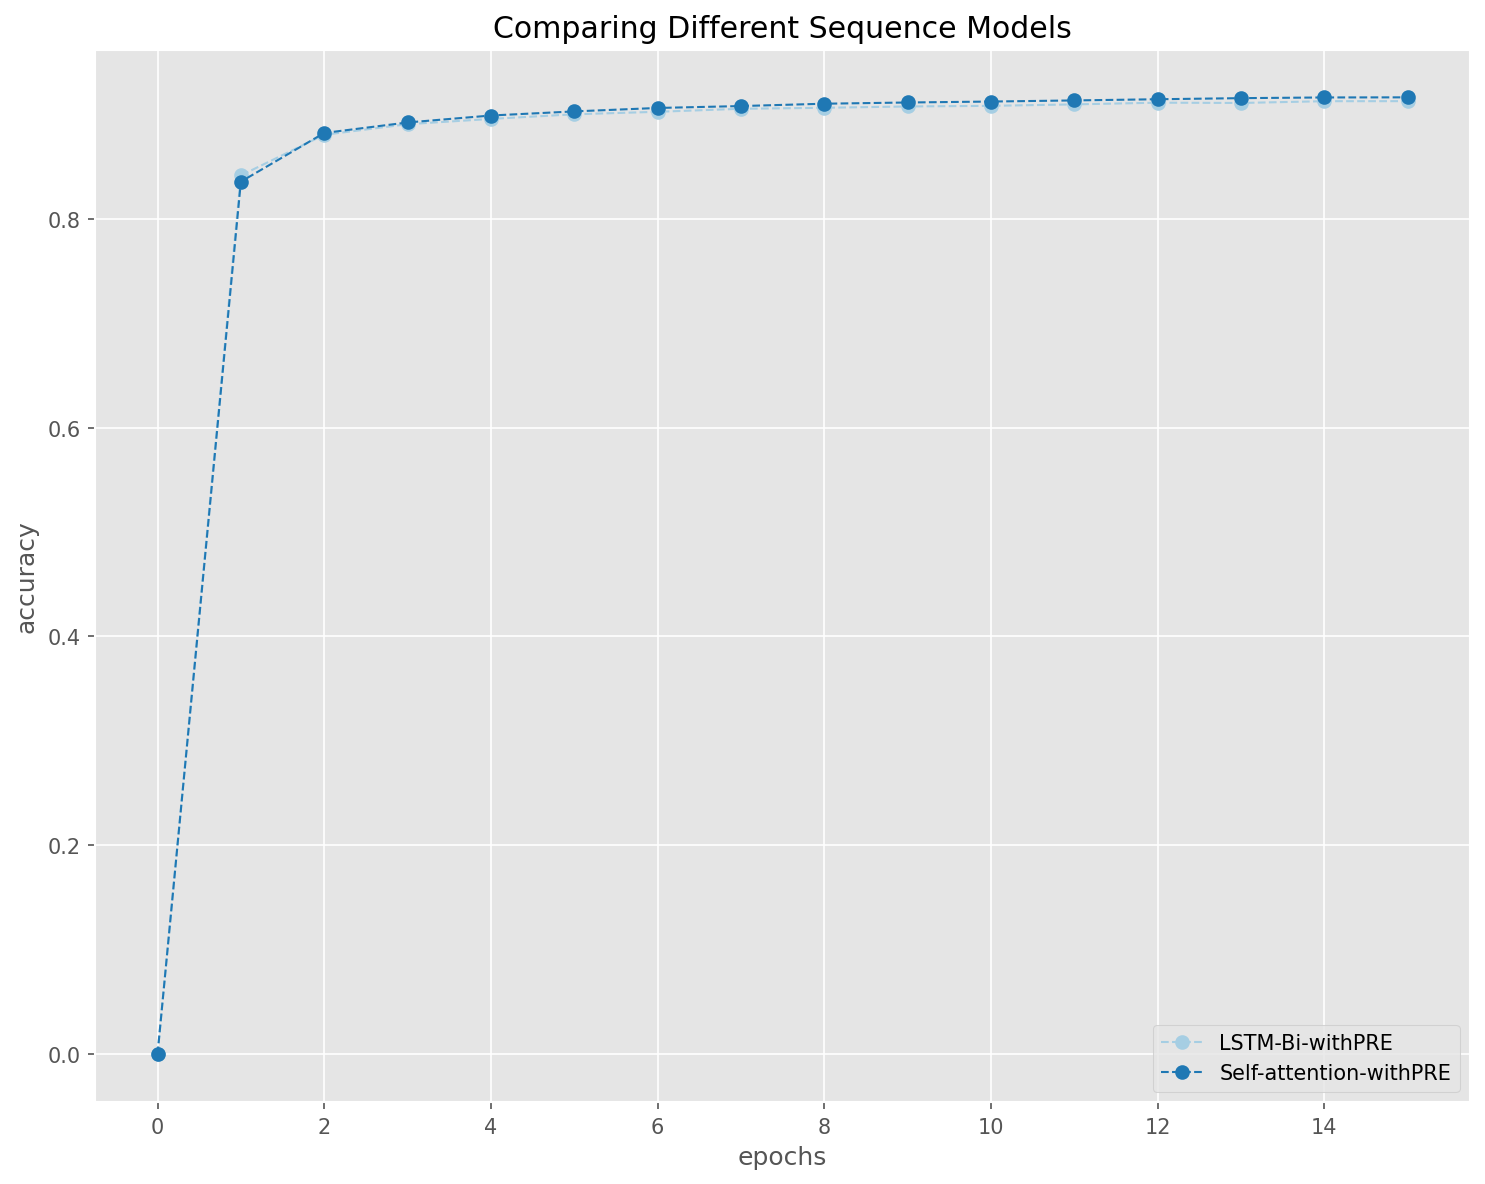

In [69]:
## Accuracy
acc = [i['accuracy'] for i in history]
val_acc = [i['val_accuracy'] for i in history]

plt.figure(figsize=(10, 8))
plt.style.use('ggplot')
for i, a in enumerate(acc):
    plt.plot(range(len(a) + 1), [0] + a,
             linestyle='--',
             marker='o',
             color=qualitative_colors[i],
             linewidth=1,
             label=model_names[i])
plt.legend()
plt.title('Comparing Different Sequence Models')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.tight_layout()
plt.show()

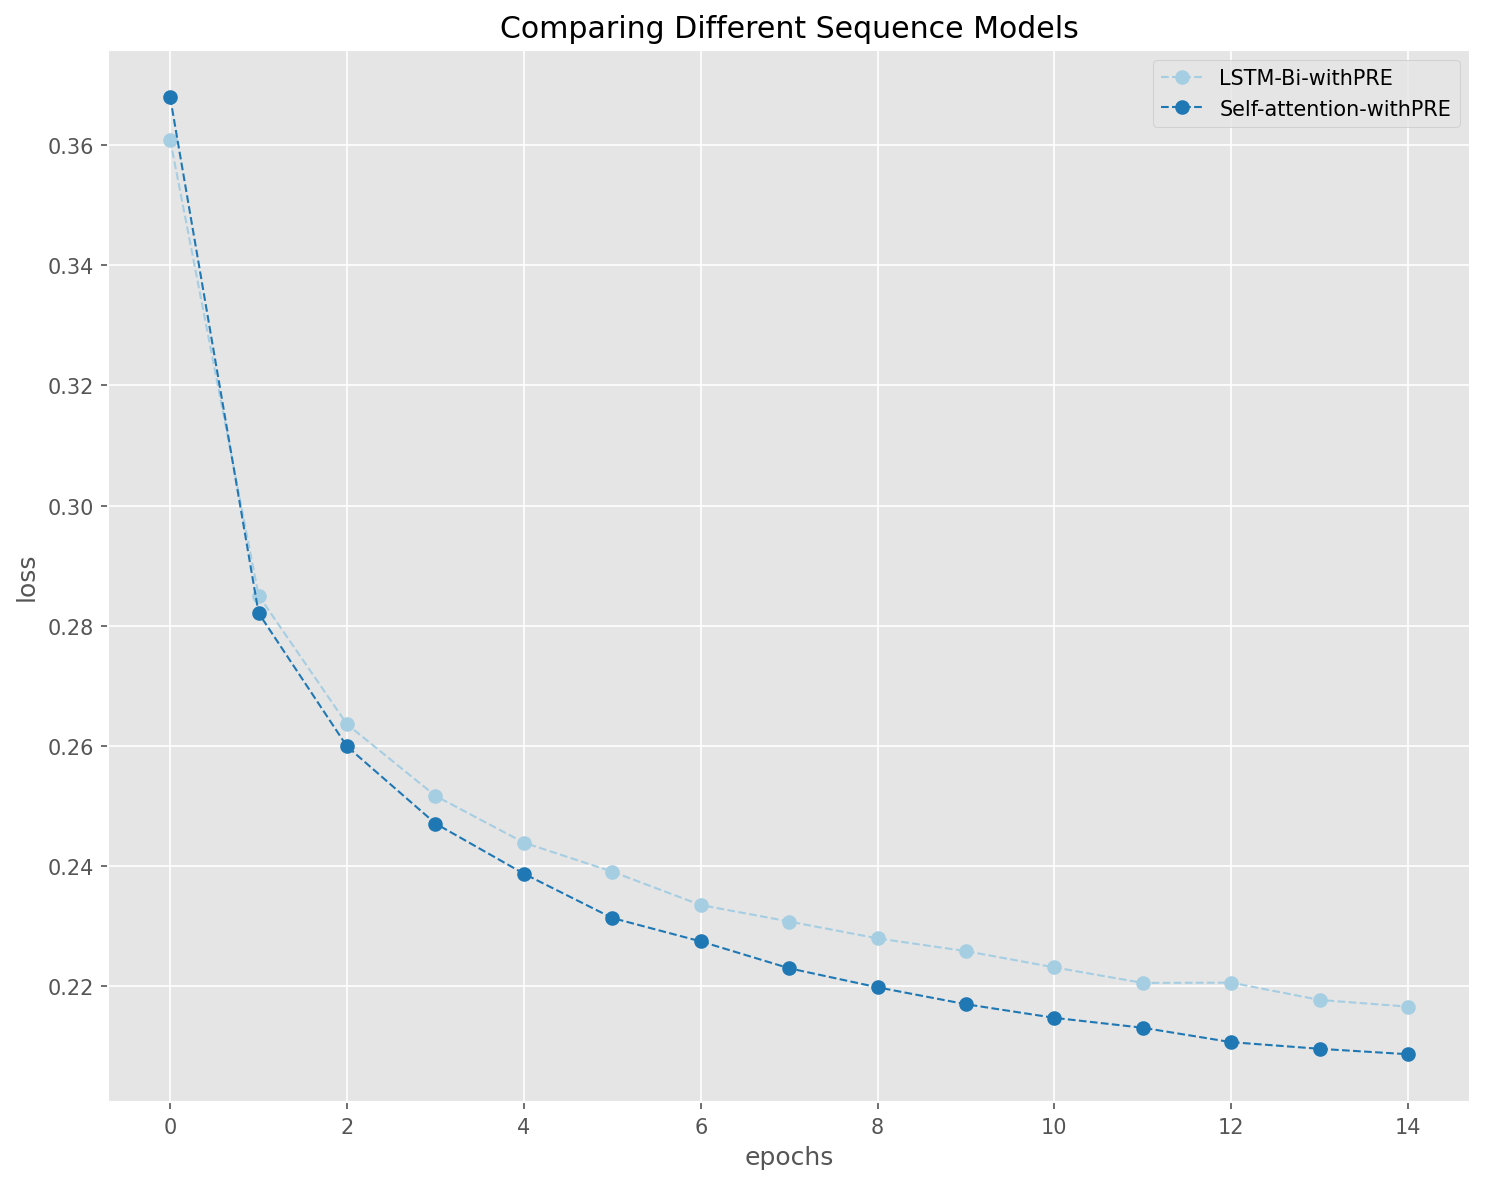

In [70]:
loss = [i['loss'] for i in history]

plt.figure(figsize=(10, 8))
plt.style.use('ggplot')
for i, a in enumerate(loss):
    plt.plot(range(len(a)),
             a,
             linestyle='--',
             marker='o',
             color=qualitative_colors[i],
             linewidth=1,
             label=model_names[i])
plt.legend()
plt.title('Comparing Different Sequence Models')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.tight_layout()
plt.show()

## Explanation: 
## An LSTM- and self-attention-based model with pre-trained embeddings

In [48]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=["negative", "positive"])

In [49]:
def model_predict_pipeline(text):
    _seq = tokenizer.texts_to_sequences(text)
    _seq_pad = keras.preprocessing.sequence.pad_sequences(_seq, maxlen=max_len)
    return np.array([[float(1 - x), float(x)]
                     for x in model3.predict(np.array(_seq_pad))])
    #return model3.predict(np.array(_seq_pad)) ## use this for logits

In [50]:
text_id = 100
model_predict_pipeline(test_text[text_id])

array([[0.49177384, 0.50822616],
       [0.51155841, 0.48844162],
       [0.52488148, 0.47511855],
       [0.53544956, 0.46455044],
       [0.59777009, 0.40222988],
       [0.55563772, 0.44436228],
       [0.49177384, 0.50822616],
       [0.53242046, 0.46757954],
       [0.53891045, 0.46108955],
       [0.59777009, 0.40222988],
       [0.61978382, 0.38021618],
       [0.54220885, 0.45779115],
       [0.58695525, 0.41304475],
       [0.51290905, 0.48709098],
       [0.57844806, 0.42155194],
       [0.61978382, 0.38021618],
       [0.53118157, 0.46881846],
       [0.61978382, 0.38021618],
       [0.60774028, 0.39225972],
       [0.53544956, 0.46455044],
       [0.59777009, 0.40222988],
       [0.53118157, 0.46881846],
       [0.58495653, 0.4150435 ],
       [0.61978382, 0.38021618],
       [0.53242046, 0.46757954],
       [0.53891045, 0.46108955],
       [0.53504276, 0.46495724],
       [0.61978382, 0.38021618],
       [0.53544956, 0.46455044],
       [0.53118157, 0.46881846],
       [0.

In [51]:
## correct label
y_test[text_id]

1

In [52]:
exp = explainer.explain_instance(test_text[text_id],
                                 model_predict_pipeline,
                                 num_features=10,
                                 top_labels=1)

exp.show_in_notebook(text=True)

## Overall model performance:  
## An LSTM- and self-attention-based model with pre-trained embeddings

In [53]:
model3.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

313/313 - 9s - loss: 0.1988 - accuracy: 0.9209


[0.19877053797245026, 0.9208999872207642]

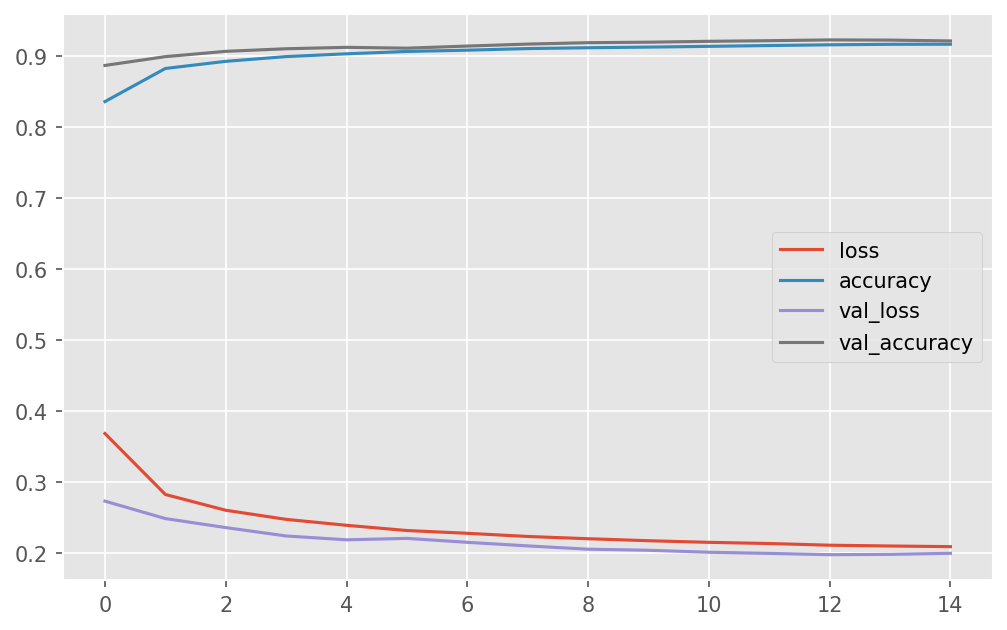

In [54]:
plot2(history3)

### Confusion Matrix

In [55]:
y_test_pred = model3.predict(X_test,
                                 batch_size=BATCH_SIZE)

In [56]:
print(len(y_test_pred))

40000


In [57]:
y_test_pred[100]

array([0.99499524], dtype=float32)

In [58]:
y_test_pred_class=[]
for p in y_test_pred:  
    if p > 0.5:
        y_test_pred_class.append(1)
    else:
        y_test_pred_class.append(0)

y_test_pred_class= np.array(y_test_pred_class)

In [59]:
print(y_test_pred_class[:10])
print(y_test[:10])

[1 0 1 1 0 0 1 0 1 0]
[1 0 1 1 0 0 1 0 1 0]


In [60]:
## gettin from stacloverflow
## https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):  ## show proportions
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6), dpi=150)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j,
                     i,
                     "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j,
                     i,
                     "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(
        accuracy, misclass))
    plt.show()

In [61]:
import sklearn
cm = sklearn.metrics.confusion_matrix(y_test,
                                      y_test_pred_class,
                                      normalize=None)

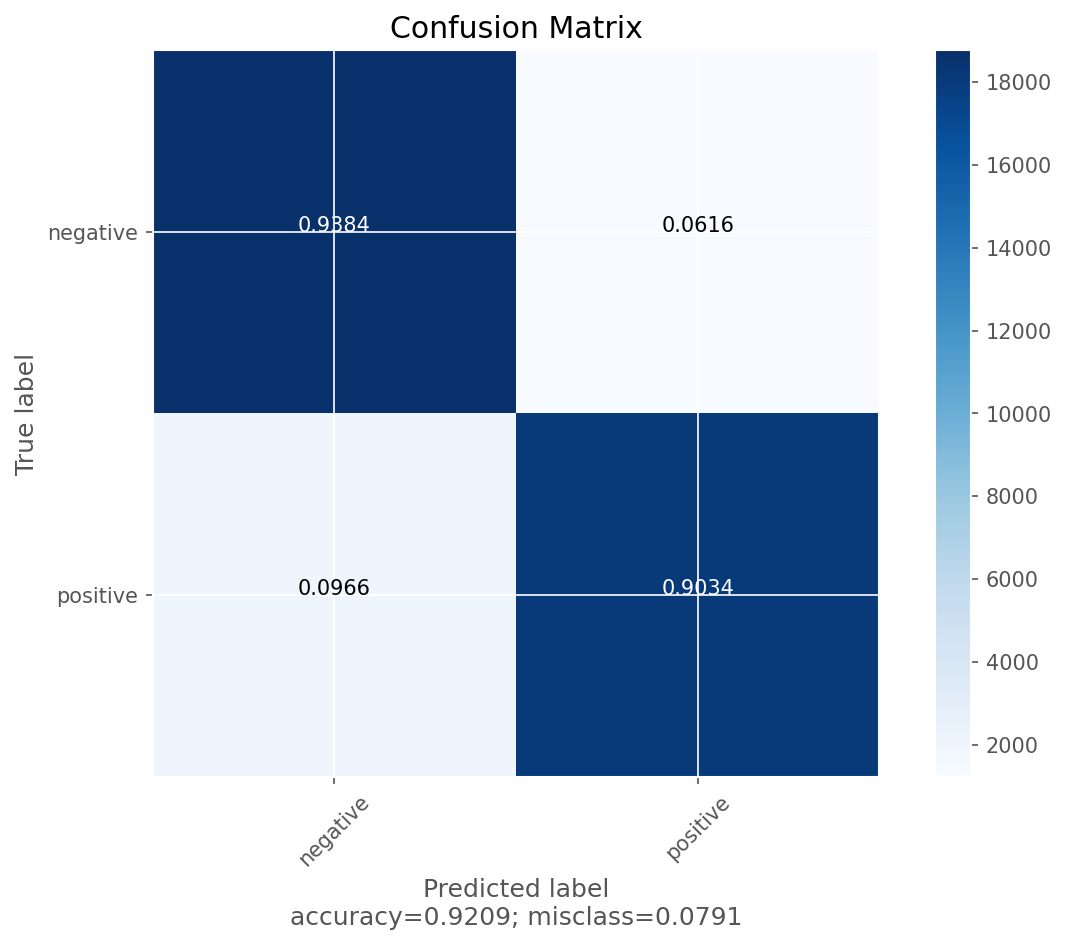

In [62]:
plot_confusion_matrix(cm,
                      normalize=True,
                      target_names=['negative', 'positive'],
                      title="Confusion Matrix")

# Project Report

## Problem:
This report aims to conduct a sentiment analysis using an attention-based recurrent neural network to evaluate the consistency of reviews with corresponding ratings retrieved from *Amazon.com*. In a review paper of sentiment analysis by deep learning (Ain et al., 2017), it is shown that a few previous analyses of recurrent neural network were conducted with a hierarchical bidirectional recurrent neural network (e.g., Chaudhuri & Ghosh, 2016) or a Long Short Term Memory (LSTM) model (e.g., Hassan, Mohammed & Azad, 2016). In these two types of models, the precision of the former model reached about 92% (the accuracy is not provided by the authors), and the accuracy of the latter reached about 80%. Other authors (Nguyen, Le, & Pham, 2016) employed a combined Deep Bidirectional Long Short Term Memory Neural Networks (DBLSTM) to analyze social data, which reached about 85% accuracy. 

However, there was not so much research on sentiment analysis with an attention-based recurrent neural network until 2016, espcially on the data of Amazon reviews. Related study of attention-based recurrent neural network was published by Wang, Huang, Zhu, and Zhao (2016). They used the attention-based LSTM to conduct an aspect-level sentiment classification based on a dataset of 4491 customers' reviews, showing the accuracy of 89.9% for binary classification. As for related analysis of Amazon reviews, Tang, Wang, and Xu (2018) used an LSTM model with the 50-d GloVe vectors as features to analyze the 34627 data points of a Amazon review dataset. This model reached about 70.2% of testing accuracy, without the attention mechanism. In this present study, I tried to utilize an attention-based LSTM to analyze a dataset consisting of 400000 reviews with pre-trained 100-d GloVe vectors as features. With the increase of sample size and dimension of feature embeddings, I expected the accuracy of this model could be further enhanced to 90%. Also, since a bidirectional LSTM model is a popular deep learning tenique as well, I tried to compare the performance of these two types of models. It is hoped that this study help to shed light on what kind of deep learning model may be more suitable for sentiment analysis if with the same pre-trained feature embeddings. 

## Data:
The data was obtained from Kaggle, an online community allowing users to access and publish datasets. The original complete dataset is called *Amazon Reviews for Sentiment Analysis*, published by Adam Bittlingmayer and last updated in Nov. 2019. Two *txt.* files comprise the whole dataset, one of which  is for training and with 3.6 million Amazon reviews; the other of which is for testing and with 0.4 million Amazon reviews. All the reviews are titled, and the titles are followed by ":" and a single space, prepended to the text. Additionally, the reviews are labeled 1 or 2, which corresponds to 1- and 2-star reviews or 4- and 5-star reviews respectively (3-star reviews, i.e. reviews with neutral sentiment, were not included in the dataset). Most of the reviews are in English, but there are a few in other languages, like Spanish. The follwing is one of a review in this dataset, whose format is clearly shown: 

*\__label__1 Huge Disappointment.: As a big time, long term Trevanian fan, I was extremely disappointed in this "experiment" by the author. I deem this effort an experiment since it is so unlike anything "Trev" (as his fans call him) has ever written before. Plain flat-out boring! It's almost as if Jane Austen had attempted to write a Twilight Zone episode under the influence of Sominex.*

In this study, I only employed a small part of the dataset, which is the *txt.* file for testing orginally, to enhance the processing efficency. However, the file is still composed of up to 400000 reviews. I splited the data into two parts, one with 360000 reviews for training and the other with 40000 for testing. With this amount of reviews, I believe the results are still compelling enough. 

## Approach:
In this study, I perfrom three different kinds of models. The architecture of the first model is presented below. This model is just used to ensure the data is pre-processed appropriately and can be sent into a neural network successfully, without any significance. As can be seen, this model is composed six layers. In the input layer, the maximal text length of the inputs is 100 after sequence padding. In the embedding layers, the original inputs are added with one more dimension with 128 semantic features. The following GlobalAveragePooling1D layer then returns a fixed-length output vector for each example by averaging over the sequence dimension. Two fully-connected dense layers with ReLU activation functions then further process the previosly obtained outpus. In the last output layer, a sigmoid activation function is adopted to output a single value for binary classification. Noteworthily, this model is only with 0.4998 accuracy and is regarded as meaningless in the following report.

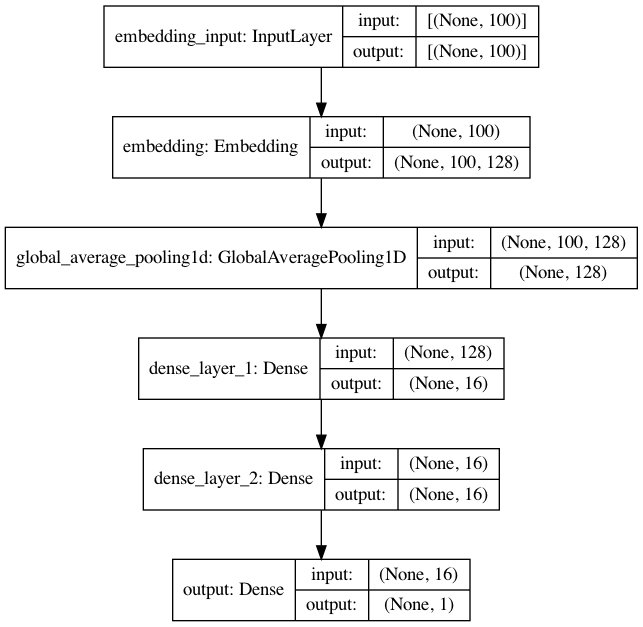

In [67]:
plot_model(model1, show_shapes=True)

In the following second model, a bidirectional LSTM technique is used. The plot below shows that the model has the same input layer as the first model. As for the embedding layer, there are only 100 semantic features added. Neverthelss, these semanic features come from the pre-trained embeddings GloVe, which are global vectors for word representation. Then, a bidirectional LSTM layer is constructed, whose outputs are further sent to last output desne layer with a sigmoid activation function to produce a single value for binary classfification. 

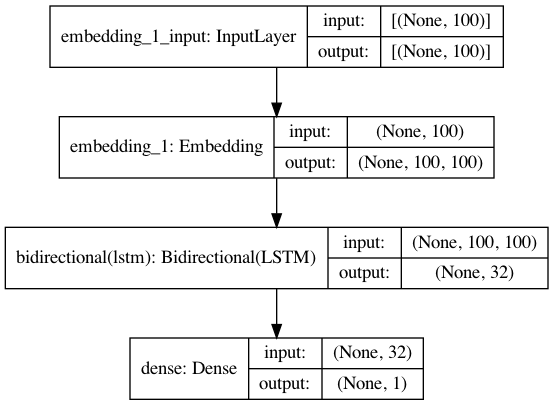

In [66]:
plot_model(model2, show_shapes=True)

In the last and the most important model, an attention-based LSTM approach is adopted. The first two layers are designed the same as Model 2. However, the LSTM layer in this model is designed with three differnts kinds of outputs, including  the hidden states of all time steps, the hidden state of the last time step, and the cell state of the last time step. The hidden states of all time steps are further fed into the self-attention layer to detect which are the important parts for the following sentiment classification. The GlobalAveragePooling1D layer then helps average over the sequence dimension gotten from the self-attention layer so that the outputs can be further concatenated with the original hidden state of the last time step from the LSTM layer. Eventually, the last two fully-connected dense layers tranform the outputs into the ultimate single value for binary classification.  

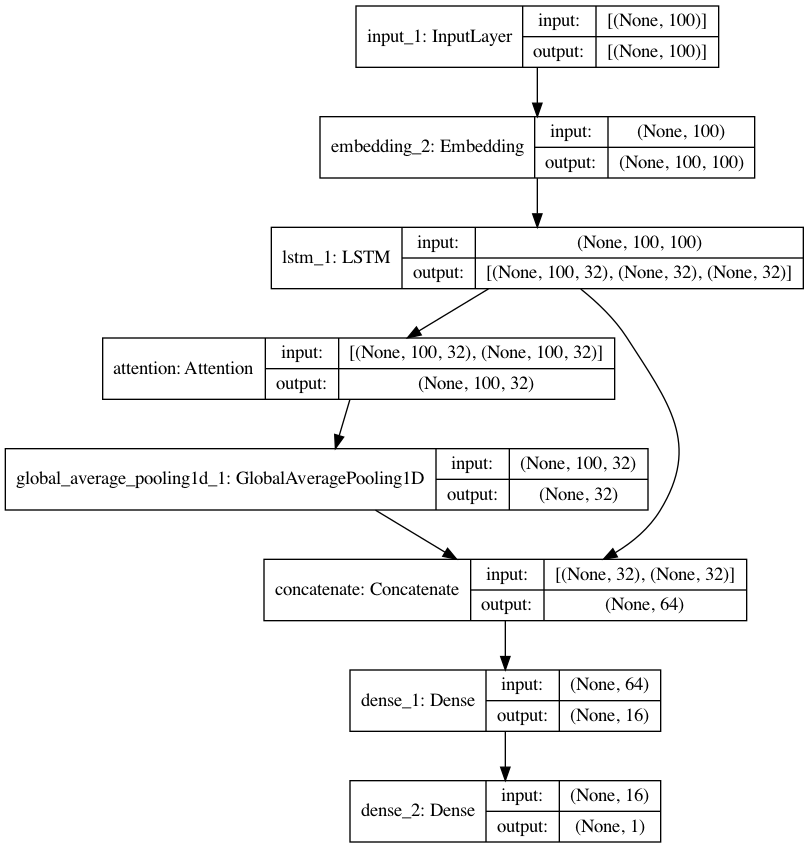

In [65]:
plot_model(model3, show_shapes=True)

## Results:
On the one hand, the bidirectional LSTM model shows its testing accuracy to be 0.9179, indicating that this model is quite effective. It is also apparent that a larger training dataset and a well pre-trained feature embeddings can greatly improve a not so complex model. On the other hand, the attention-based LSTM model demonstrates that without the bidirectional mechanism, the self-attention layer can further enhance the accuacy to 0.9209. 

To compare the two models, it can be found that during the two training processes, the validation processes in the 15 epochs show almost the same accuracy, with their traces almost overlap in the plot of coding chunk No.69. The performance of the two models are very similar. Nonetheless, if a person futher examines the plot of coding chunk No.70, he or she can find that the loss in the attention-based LSTM model drops more quickly, suggesting that this model may be more efficient than the bidirectional LSTM model. With slighly higher accuracy and higher efficiency in decreasing the loss, I believe an attention-based LSTM model is a more appropriate and effective model to conduct a sentiment analysis on reviews of binary classification. 

## Analysis:
Before training the data, I preprocessed the raw text with the following step: (1) removing unnecessary html tags; (2) removing punctuations and numbers; (3) removing unnecessary multiple spaces; (4) lowercasing the text. Also, only the top 10000 words in the text of the training dataset were taken into account and given sequences. Most of the text length is around 25 to 110, so the maximal length was set to 100. Furthermoe, since I discovered most of the authors of reviews revealed their sentiments at the beginning of the text, truncating and padding were applied to the end of the text. As for the hyperparameters of the two compared models, the batch size is 128, the number of epochs is 15, the dorpout rate is 0.2, and 0.2 of the training dataset are used for validation. 

At the end of the report, a few explanations were given based on the attention-based LSTM model. It can be seen that the correct label of an example text of ID.100 is "positive," and the model predicted it successfully, determing it with the 99% probability of positive. The confusion matrix shows the accuracy of 92% to successfully predict the correct label. There is only 7% of misclassification. Interestingly, misclassfication happens more often when the origianl true label of the text is positive than when that is negative, about 3% higher. I speculate misclassfication occurs because  people sometimes use "ironically positive" or "ironically negative" words to express their "dissatisfaction" or "satisfaction" respectively, causing the inconsistency between the rating and text of a review. The model may be unable to tell a text is ironic or not during prediction. 

## Conclusions:
This report shows that a not so complex model, such as a bidirectional LSTM model, can be improved by a larger training dataset and a well pre-trained feature embeddings. Additionally, the performance of a bidirectional LSTM model and an attention-based LSTM model may be similarly effective when doing a sentiment analysis. However, the latter model may be more appropriate because of its slightly higher accuracy and higher efficiency in decreasing the loss. An attention-based LSTM model is thus recommended to conduct a sentiment analysis on reviews of binary classification.

## References:
- Ain, Q.T., Ali, M., Riaz, A., Noureen, A., Kamran, M., Hayat, B., & Rehman, A. (2017). Sentiment Analysis Using Deep Learning Techniques: A Review. *International Journal of Advanced Computer Science and Applications, 8* (6).
- Bittlingmayer, Adam. (2017). *Amazon Reviews for Sentiment Analysis* (Version 7) [Data set]. Kaggle. https://www.kaggle.com/bittlingmayer/amazonreviews
- Chaudhuri A., & Ghosh S.K. (2016). Sentiment Analysis of Customer Reviews Using Robust Hierarchical Bidirectional Recurrent Neural Network. In: R. Silhavy, R. Senkerik, Z. Oplatkova, P. Silhavy, Z. Prokopova (Eds.), *Artificial Intelligence Perspectives in Intelligent Systems. Advances in Intelligent Systems and Computing, vol 464.* (pp.249-261) Springer, Cham. 
- Hassan, A., Mohammed, N.,& Azad, A. (2016). Sentiment Analysis on Bangla and Romanized Bangla Text (BRBT) using Deep Recurrent models.
- Nguyen, N.K., Le, AC.,& Pham, H.T. (2016). Deep Bi-directional Long Short-Term Memory Neural Networks for Sentiment Analysis of Social Data. In: VN. Huynh, M. Inuiguchi, B. Inuiguchi, B Le., T Denoeux. (Eds.) *Integrated Uncertainty in Knowledge Modelling and Decision Making. Lecture Notes in Computer Science, vol 9978.* Springer, Cham. 
- Tan, W., Wang, X., & Xu, X. (2018). Analysis for Amazon Reviews.
- Wang, Y., Huang, M., Zhu, X., & Zhao, L. (2016, November). *Attention-based LSTM for Aspect-level Sentiment Classification.* Proceedings of the 2016 Conference on Empirical Methods in Natural Language Processing, Austin, Texas